In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from mahts import HTSDistributor
from tsforest.utils import make_time_range

# local modules
import sys
sys.path.append("../lib/")
from utils import (compute_scaling, compute_weights, reduce_mem_usage, 
                   compute_scales_by_level, compute_weights_by_level)
from evaluation import _WRMSSEEvaluator, WRMSSEEvaluator, Evaluator, WRMSSEEvaluatorL12
from trend import TrendEstimator, apply_robust_trend_correction

***
## data loading

In [3]:
data = (pd.read_parquet("../input/train_dataframe.parquet", 
                        columns=["ts_id","item_id", "dept_id", "cat_id", 
                                 "store_id", "state_id", "q", "ds"])
        .rename({"q":"y"}, axis=1))

hierarchy = pd.read_parquet("../input/hierarchy.parquet")
hierarchy_raw = pd.read_parquet("../input/hierarchy_raw.parquet")

In [6]:
infile = open("../input/encoders.pkl", "rb")
encoders = pickle.load(infile)
infile.close()

In [9]:
files_approach1 = [fn for fn in os.listdir("../output/") if "forecast_app1" in fn]
forecasts_approach1 = list()
for file in files_approach1:
    forecasts_approach1.append(pd.read_csv(f"../output/{file}", parse_dates=["ds"]))

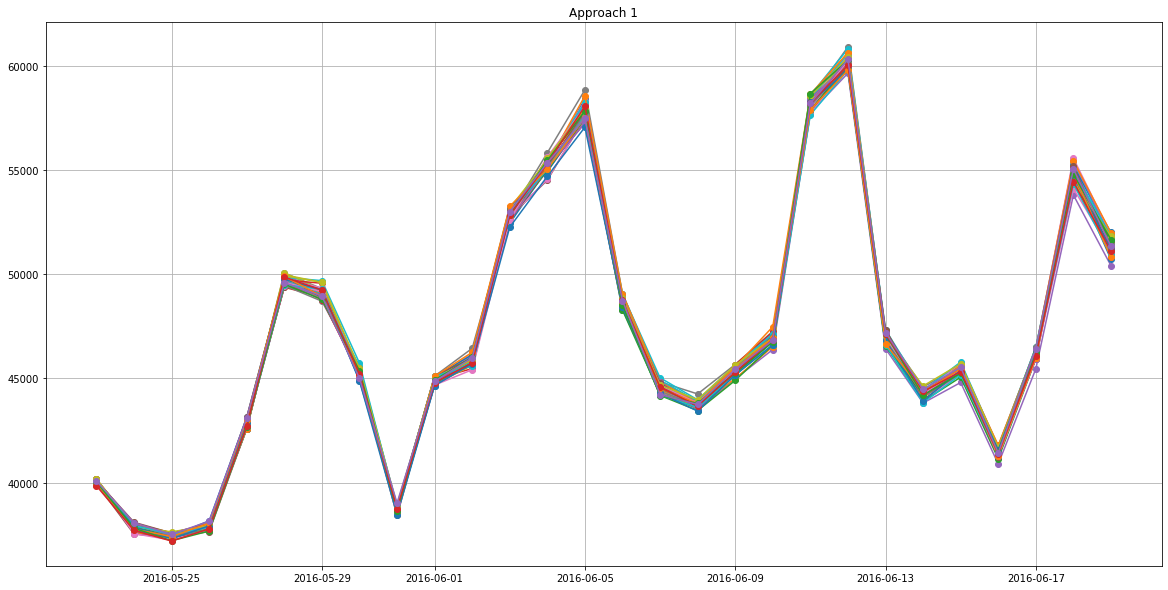

In [10]:
plt.figure(figsize=(20,10))
plt.title("Approach 1")

for forecast in forecasts_approach1:
    forecast_level1 = forecast.groupby("ds")["y_pred"].sum().reset_index()
    plt.plot_date(forecast_level1.ds, forecast_level1.y_pred, "o-")
plt.grid()
plt.show()

In [11]:
files_approach2 = [fn for fn in os.listdir("../output/") if "forecast_app2" in fn]
forecasts_approach2 = list()
for file in files_approach2:
    forecasts_approach2.append(pd.read_csv(f"../output/{file}", parse_dates=["ds"]))

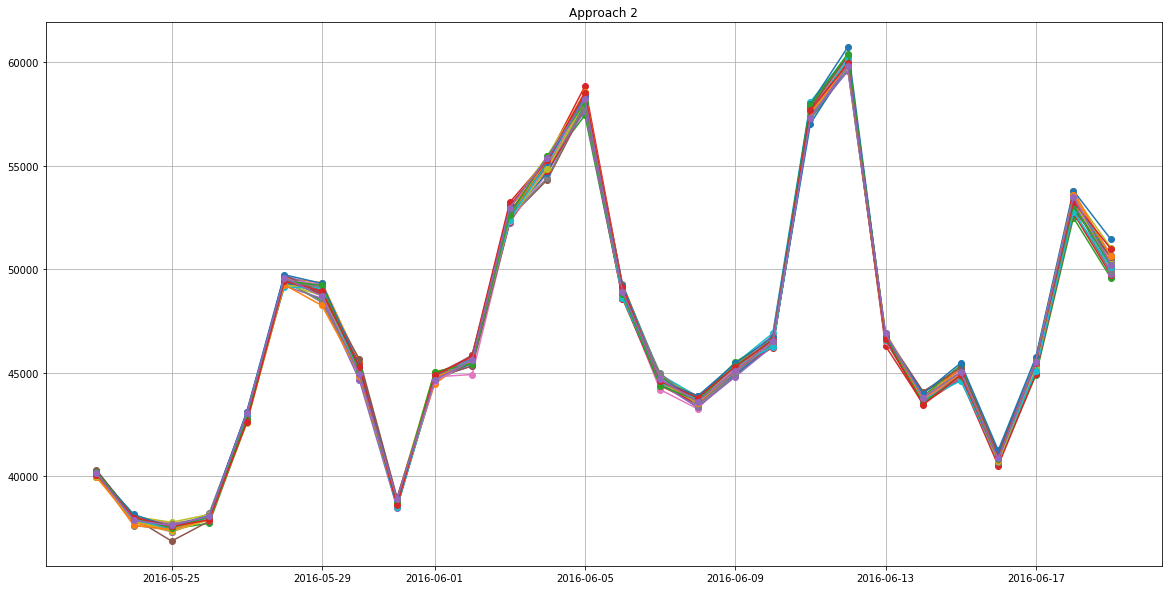

In [12]:
plt.figure(figsize=(20,10))
plt.title("Approach 2")

for forecast in forecasts_approach2:
    forecast_level1 = forecast.groupby("ds")["y_pred"].sum().reset_index()
    plt.plot_date(forecast_level1.ds, forecast_level1.y_pred, "o-")
plt.grid()
plt.show()

In [16]:
predict_start = pd.to_datetime("2016-05-23")
predict_end = pd.to_datetime("2016-06-19")

In [17]:
%%time
hierarchy_dict = {"root":hierarchy_raw.store_id.unique()}

for store_id in hierarchy_raw.store_id.unique():
    hierarchy_dict[store_id] = hierarchy_raw.query("store_id == @store_id").id.unique()

hts = HTSDistributor(hierarchy_dict)

CPU times: user 3min 17s, sys: 26.1 s, total: 3min 43s
Wall time: 3min 49s


***
## trend correction on level 1

In [28]:
kwargs_list = [
    # round 0
    ({"primary_bandwidths": np.arange(41, 47),
     "middle_bandwidth": 33,
     "final_bandwidth": 15,
     "alpha": 4,
      "drop_last_n": 0},
     {"primary_bandwidths": np.arange(112, 119),
     "middle_bandwidth": 38,
     "final_bandwidth": 33,
     "alpha": 2}),
    
    ({"primary_bandwidths": np.arange(42, 46),
     "middle_bandwidth": 19,
     "final_bandwidth": 18,
     "alpha": 4,
      "drop_last_n": 0},
     {"primary_bandwidths": np.arange(112, 119),
     "middle_bandwidth": 30,
     "final_bandwidth": 33,
     "alpha": 1}),
    
    ({"primary_bandwidths": np.arange(42, 46),
     "middle_bandwidth": 35,
     "final_bandwidth": 15,
     "alpha": 4,
      "drop_last_n": 0},
     {"primary_bandwidths": np.arange(112, 119),
     "middle_bandwidth": 42,
     "final_bandwidth": 33,
     "alpha": 10}),
    
    # round 2
    ({"primary_bandwidths": np.arange(20, 55),
     "middle_bandwidth": 55,
     "final_bandwidth": 38,
     "alpha": 0,
      "drop_last_n": 1},
     {"primary_bandwidths": np.arange(112, 119),
     "middle_bandwidth": 43,
     "final_bandwidth": 33,
     "alpha": 0}),
    
    ({"primary_bandwidths": np.arange(21, 54),
     "middle_bandwidth": 55,
     "final_bandwidth": 41,
     "alpha": 1,
      "drop_last_n": 1},
     {"primary_bandwidths": np.arange(112, 119),
     "middle_bandwidth": 41,
     "final_bandwidth": 33,
     "alpha": 0}),
    
    ({"primary_bandwidths": np.arange(24, 56),
     "middle_bandwidth": 54,
     "final_bandwidth": 41,
     "alpha": 1,
      "drop_last_n": 1},
     {"primary_bandwidths": np.arange(112, 119),
     "middle_bandwidth": 31,
     "final_bandwidth": 33,
     "alpha": 10}),
        
    # round 3
    ({"primary_bandwidths": np.arange(23, 48),
     "middle_bandwidth": 46,
     "final_bandwidth": 14,
     "alpha": 8,
      "drop_last_n": 1},
     {"primary_bandwidths": np.arange(103, 119),
     "middle_bandwidth": 52,
     "final_bandwidth": 31,
     "alpha": 10}),
    
    ({"primary_bandwidths": np.arange(29, 41),
     "middle_bandwidth": 54,
     "final_bandwidth": 18,
     "alpha": 5,
      "drop_last_n": 1},
     {"primary_bandwidths": np.arange(111, 116),
     "middle_bandwidth": 88,
     "final_bandwidth": 37,
     "alpha": 10}),
    
    ({"primary_bandwidths": np.arange(29, 43),
     "middle_bandwidth": 50,
     "final_bandwidth": 14,
     "alpha": 7,
      "drop_last_n": 1},
     {"primary_bandwidths": np.arange(112, 115),
     "middle_bandwidth": 70,
     "final_bandwidth": 37,
     "alpha": 10}),
    
    # round 4
    ({"primary_bandwidths": np.arange(16, 30),
     "middle_bandwidth": 39,
     "final_bandwidth": 29,
     "alpha": 5,
      "drop_last_n": 1},
     {"primary_bandwidths": np.arange(107, 116),
     "middle_bandwidth": 156,
     "final_bandwidth": 36,
     "alpha": 0}),
    
    ({"primary_bandwidths": np.arange(15, 33),
     "middle_bandwidth": 43,
     "final_bandwidth": 25,
     "alpha": 6,
      "drop_last_n": 1},
     {"primary_bandwidths": np.arange(110, 114),
     "middle_bandwidth": 154,
     "final_bandwidth": 39,
     "alpha": 0}),
    
    ({"primary_bandwidths": np.arange(16, 30),
     "middle_bandwidth": 39,
     "final_bandwidth": 29,
     "alpha": 5,
      "drop_last_n": 1},
     {"primary_bandwidths": np.arange(106, 118),
     "middle_bandwidth": 155,
     "final_bandwidth": 31,
     "alpha": 0}),
        
    # round 5
    ({"primary_bandwidths": np.arange(16, 18),
     "middle_bandwidth": 31,
     "final_bandwidth": 38,
     "alpha": 9,
      "drop_last_n": 1},
     {"primary_bandwidths": np.arange(112, 114),
     "middle_bandwidth": 62,
     "final_bandwidth": 36,
     "alpha": 9}),
        
    ({"primary_bandwidths": np.arange(16, 18),
     "middle_bandwidth": 31,
     "final_bandwidth": 40,
     "alpha": 4,
      "drop_last_n": 1},
     {"primary_bandwidths": np.arange(111, 113),
     "middle_bandwidth": 65,
     "final_bandwidth": 37,
     "alpha": 10}),
    
    ({"primary_bandwidths": np.arange(16, 18),
     "middle_bandwidth": 32,
     "final_bandwidth": 41,
     "alpha": 8,
      "drop_last_n": 1},
     {"primary_bandwidths": np.arange(109, 114),
     "middle_bandwidth": 38,
     "final_bandwidth": 39,
     "alpha": 9}),
    
    # round 6      
    ({"primary_bandwidths": np.arange(37, 39),
     "middle_bandwidth": 28,
     "final_bandwidth": 18,
     "alpha": 2,
      "drop_last_n": 1},
     {"primary_bandwidths": np.arange(108, 119),
     "middle_bandwidth": 110,
     "final_bandwidth": 34,
     "alpha": 0}),
        
    ({"primary_bandwidths": np.arange(26, 40),
     "middle_bandwidth": 34,
     "final_bandwidth": 16,
     "alpha": 2,
      "drop_last_n": 1},
     {"primary_bandwidths": np.arange(108, 119),
     "middle_bandwidth": 92,
     "final_bandwidth": 35,
     "alpha": 0}),
    
    ({"primary_bandwidths": np.arange(28, 40),
     "middle_bandwidth": 44,
     "final_bandwidth": 16,
     "alpha": 0,
      "drop_last_n": 1},
     {"primary_bandwidths": np.arange(108, 119),
     "middle_bandwidth": 85,
     "final_bandwidth": 34,
     "alpha": 2}),
    
    # round 7    
    ({"primary_bandwidths": np.arange(41, 45),
     "middle_bandwidth": 44,
     "final_bandwidth": 15,
     "alpha": 10,
      "drop_last_n": 0},
     {"primary_bandwidths": np.arange(112, 119),
     "middle_bandwidth": 28,
     "final_bandwidth": 33,
     "alpha": 1}),
    
    ({"primary_bandwidths": np.arange(41, 45),
     "middle_bandwidth": 48,
     "final_bandwidth": 17,
     "alpha": 9,
      "drop_last_n": 0},
     {"primary_bandwidths": np.arange(112, 119),
     "middle_bandwidth": 124,
     "final_bandwidth": 33,
     "alpha": 3}),
    
    ({"primary_bandwidths": np.arange(17, 47),
     "middle_bandwidth": 47,
     "final_bandwidth": 16,
     "alpha": 8,
      "drop_last_n": 0},
     {"primary_bandwidths": np.arange(112, 117),
     "middle_bandwidth": 106,
     "final_bandwidth": 36,
     "alpha": 2}),
]

In [29]:
forecast = forecasts_approach1[0]

In [30]:
%%time
forecast_level3 = apply_robust_trend_correction(data, forecast, level=3, kwargs_list=kwargs_list)

fcl1_v0 = forecast.groupby(["ds"])["y_pred"].sum().reset_index()
fcl1_v1 = forecast_level3.groupby(["ds"])["y_pred"].sum().reset_index()

CPU times: user 17.4 s, sys: 4.22 s, total: 21.6 s
Wall time: 22.8 s


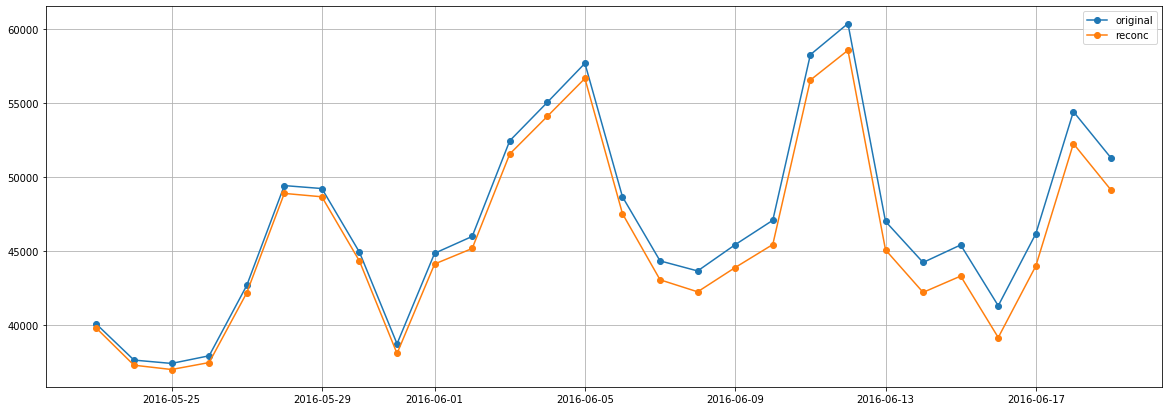

In [31]:
plt.figure(figsize=(20,7))
plt.plot_date(fcl1_v0.ds, fcl1_v0.y_pred, "o-", label="original")
plt.plot_date(fcl1_v1.ds, fcl1_v1.y_pred, "o-", label="reconc")
plt.grid()
plt.legend(loc="best")
plt.show()

***
## trend correction on level 3

In [33]:
forecasts_approach1_corrected = list()

for forecast in tqdm(forecasts_approach1):
    forecast_level3 = apply_robust_trend_correction(data, forecast, level=3, kwargs_list=kwargs_list)
    forecast_level3["store_id"] = encoders["store"].inverse_transform(forecast_level3.store_id)
    
    forecast_level1 = forecast_level3.groupby("ds")["y_pred"].sum().reset_index().set_index("ds").rename({"y_pred":"root"}, axis=1)
    forecast_level3 = forecast_level3.pivot(index="ds", columns="store_id", values="y_pred")
    forecast = forecast.merge(hierarchy.loc[:, ["id","item_id","store_id"]], how="left")
    forecast_level12 = forecast.pivot(index="ds", columns="id", values="y_pred")
    forecast_concat = pd.concat([forecast_level1, forecast_level3, forecast_level12], axis=1)
    
    fcst_reconc = hts.compute_forecast_proportions(forecast_concat)
    fcst_reconc.set_index(forecast_concat.index, inplace=True)
    fcst_reconc = fcst_reconc.loc[:, hts.bottom_nodes].transpose()
    forecast_reconc = (
        fcst_reconc
        .reset_index()
        .rename({"index":"id"}, axis=1)
        .melt(id_vars="id", 
              value_vars=[predict_start+pd.DateOffset(days=i) for i in range(28)],
              value_name="y_pred"))
    forecast_reconc["id"] = encoders["id"].transform(forecast_reconc.id)
    forecasts_approach1_corrected.append(forecast_reconc)

100%|██████████| 35/35 [21:52<00:00, 37.51s/it]


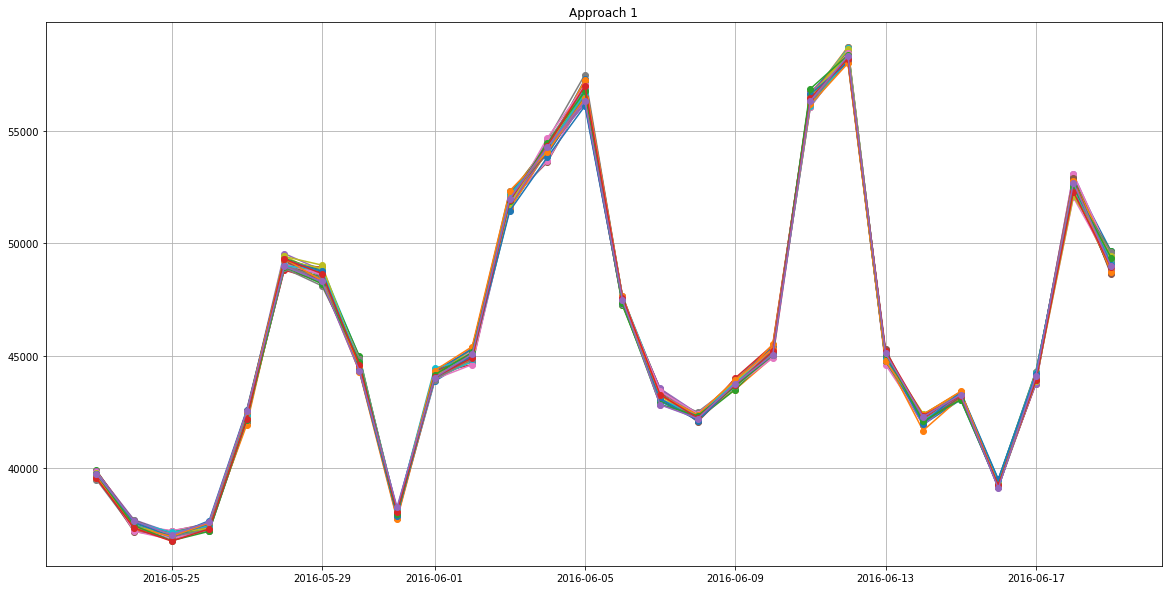

In [34]:
plt.figure(figsize=(20,10))
plt.title("Approach 1")

for forecast in forecasts_approach1_corrected:
    forecast_level1 = forecast.groupby("ds")["y_pred"].sum().reset_index()
    plt.plot_date(forecast_level1.ds, forecast_level1.y_pred, "o-")
plt.grid()
plt.show()

In [35]:
forecasts_approach2_corrected = list()

for forecast in tqdm(forecasts_approach2):
    forecast_level3 = apply_robust_trend_correction(data, forecast, level=3, kwargs_list=kwargs_list)
    forecast_level3["store_id"] = encoders["store"].inverse_transform(forecast_level3.store_id)
    
    forecast_level1 = forecast_level3.groupby("ds")["y_pred"].sum().reset_index().set_index("ds").rename({"y_pred":"root"}, axis=1)
    forecast_level3 = forecast_level3.pivot(index="ds", columns="store_id", values="y_pred")
    forecast = forecast.merge(hierarchy.loc[:, ["id","item_id","store_id"]], how="left")
    forecast_level12 = forecast.pivot(index="ds", columns="id", values="y_pred")
    forecast_concat = pd.concat([forecast_level1, forecast_level3, forecast_level12], axis=1)
    
    fcst_reconc = hts.compute_forecast_proportions(forecast_concat)
    fcst_reconc.set_index(forecast_concat.index, inplace=True)
    fcst_reconc = fcst_reconc.loc[:, hts.bottom_nodes].transpose()
    forecast_reconc = (
        fcst_reconc
        .reset_index()
        .rename({"index":"id"}, axis=1)
        .melt(id_vars="id", 
              value_vars=[predict_start+pd.DateOffset(days=i) for i in range(28)],
              value_name="y_pred"))
    forecast_reconc["id"] = encoders["id"].transform(forecast_reconc.id)
    forecasts_approach2_corrected.append(forecast_reconc)

100%|██████████| 25/25 [16:19<00:00, 39.17s/it]


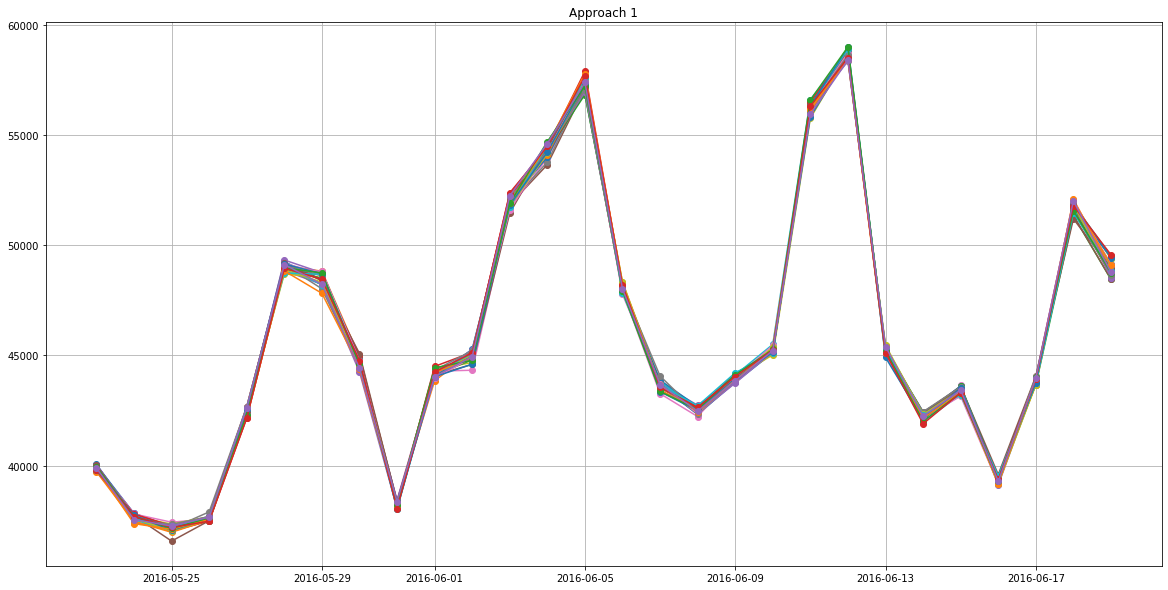

In [36]:
plt.figure(figsize=(20,10))
plt.title("Approach 1")

for forecast in forecasts_approach2_corrected:
    forecast_level1 = forecast.groupby("ds")["y_pred"].sum().reset_index()
    plt.plot_date(forecast_level1.ds, forecast_level1.y_pred, "o-")
plt.grid()
plt.show()

***

In [37]:
all_forecasts = forecasts_approach1_corrected + forecasts_approach2_corrected

In [38]:
forecast_blend = all_forecasts[0].copy(deep=True)
forecast_blend["y_pred"] = trimean([forecast.y_pred.values for forecast in all_forecasts], axis=0)

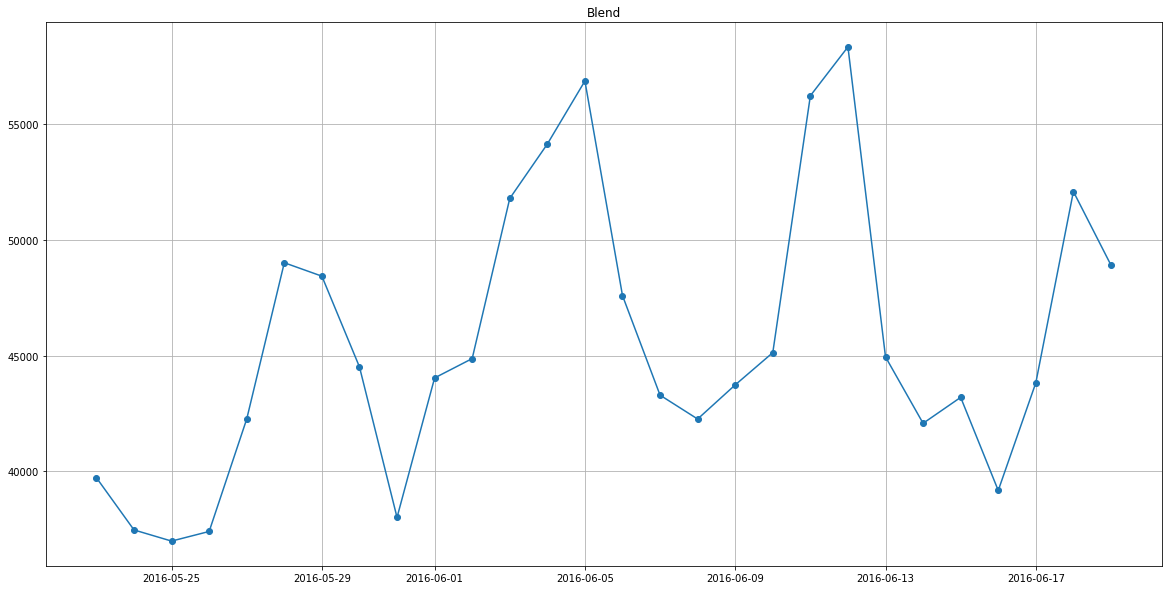

In [39]:
plt.figure(figsize=(20,10))
plt.title("Blend")
forecast_level1 = forecast_blend.groupby("ds")["y_pred"].sum().reset_index()
plt.plot_date(forecast_level1.ds, forecast_level1.y_pred, "o-")
plt.grid()
plt.show()

***
## submission file

In [49]:
submission = pd.read_csv("../input/sample_submission.csv")

In [51]:
forecast_evaluation = pd.merge(forecast_blend.rename({"id":"ts_id"}, axis=1),
                               hierarchy.loc[:, ["ts_id","id"]], 
                               how="left", on="ts_id")
forecast_evaluation["id"] = forecast_evaluation.id.map(lambda x: x+"_evaluation")

In [53]:
forecast_evaluation = (forecast_evaluation
                       .pivot(index="id", columns="ds", values="y_pred")
                       .reset_index())
forecast_evaluation.columns = ["id"] + [f"F{i}" for i in range (1,29)]

In [55]:
submission = pd.merge(submission.loc[:, ["id"]], forecast_evaluation, how="left", on="id").fillna(0)

In [61]:
submission.to_csv("../submissions/forecast_blend1.csv", index=False)

In [62]:
!ls -halt ../submissions/

total 172288
-rw-r--r--   1 m0v00aw  CL\Domain Users    20M Jun 30 16:58 forecast_blend1.csv
-rw-r--r--   1 m0v00aw  CL\Domain Users    20M Jun 30 16:44 forecast_blend4.csv
drwxr-xr-x   6 m0v00aw  CL\Domain Users   192B Jun 30 16:44 .
-rw-r--r--   1 m0v00aw  CL\Domain Users    20M Jun 30 16:42 forecast_blend3.csv
-rw-r--r--   1 m0v00aw  CL\Domain Users    20M Jun 30 16:38 forecast_blend2.csv
drwxr-xr-x  11 m0v00aw  CL\Domain Users   352B Jun 30 03:22 ..


***